# MLcourseProject - Deep Learning Your Brain
## Classification of Movement Execution and Imagination using EEG Signals
This repository is for the Advanced Topics in ML project Spring Semester 2019.

# Group members: 
Tim Fischer, Özhan Özen, Joaquin Penalver-Andres

# Project Description:
The project will focus on classification of movement imagination tasks using EEG signals. 

It is proven that thinking about different movement that one plans to execute, generates a different neural fooprint. This footprint can be detected by means of an EEG recording device. The goal of this project is to classify different movements that subjects may think of or execute. 

# DataSet
We will base our project on an existing dataset (link: https://www.physionet.org/physiobank/database/eegmmidb/#experimental-protocol ). 

The physionet dataset contains the following classes, with 109 subjects and 64 EGG Channels (Subjects 88, 92 and 100 have overlapping events. Please exclude these subjects).

LABELS	|	DESCRIPTION
------------------------------
0 	|	Baseline, eyes open           
1 	|	Baseline, eyes closed         
2 	|	Motor execution: Left Hand           
3 	|	Motor execution: Right Hand          
4 	|	Motor imagery: Left Hand           
5 	|	Motor imagery: Right Hand          
6 	|	Motor execution: Both Hands          
7 	|	Motor execution: Both Feet           
8 	|	Motor Im: Both Hands          
9 	|	Motor imagery: Both Feet           

We have chosen to include 8 classes (baselines are excluded) for classification. 

## Loading of Modules


In [1]:
%matplotlib inline
#%matplotlib widget
%load_ext autoreload
%autoreload 2


import numpy as np
from visualisations import eeg_sample_plot, events_distribution_plot, curve_name_gen
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor
from torch.utils.data import DataLoader
from datasets import ChannelsVoltageDataset
from neural_nets.nn_models_getter import get_nn_model
from optimizers import get_optimizer
from utils_train import fit, test, plot_all_metrics, plot_val_metrics, final_test_acc
from configs import configs_ozhan, configs_tim, configs_joaquin, configs_final
from data_loader_creation import get_dataloader_objects
from classification_results import results_storer
from datetime import datetime
import torch
import matplotlib.pyplot as plt

# You need to choose a config file to setup the traing. An axample config file is as following.

#### Config class name to include in the list at the bottom.
class Config3DCNN_NOTCropped(DefaultConfig):
    verbose = 'CRITICAL'
    
    config_name = '3D CNN'
    config_remark = '3D CNN'
   
   #### Number of subjects.
    nSubj = 20 
    selected_subjects = selected_subjects[:nSubj]
    
   #### Selection of the network and optimizer, these names have to be in .py files.
    nn_list = ['ConvNet3D']  # Extend if you want more. Add them in the nn_models_getter.py module
    nn_selection_idx = 0
    optimizer_list = ['Adam']  # Extend if you want more. Add them in the optimizers.py module
    optimizer_selection_idx = 0  # Idx corresponds to entry optimizer_list (find below)
    learning_rate = 1e-3
    weight_decay = 1e-4
    
   #### Setting up a scheduler for learning rate.
    scheduler = True  
    schStepSize = 20
    schGamma = 0.5
    
   #### Number of epochs and early stopping settings.
    num_of_epochs = 50
    batch_size = 128
    use_early_stopping = True
    es_patience = num_of_epochs
    
   #### Normalization/augmentation settings
    normalize = True
    augment_with_gauss_noise = False
    augmentation_factor = 2
    augment_std_gauss = 0.2
    dropOut = False
    dropOutChOnly = False
    dropOutTimeOnly = False
    dropOutTilePerc = 0.5
    dropOutTimeTile = 40
    dropOutChannelTile = 8
    
   #### Epoch Settings
    time_before_event_s = 0.0  # Epochsize parameter: Start time before event.
    time_after_event_s = 2.0  # Epochsize parameter: Time after event.
    downSample = 1
    
   #### To make number of data points dividable with 10
    show_events_distribution = False
    removeLastData = True
    
   #### To make channel dimension 2d, or cropping the time axis.
    Elec2D = True
    wSize = 10
    wCropped = False
    
    
#### All the classes in this list will be trained.
list_of_configs = [Config3DCNN_Cropped]

## Selecting the configuration (configs_final is the final one)

In [2]:
""" USER: SELECT THE CONFIGURATION YOU NEED """
myList = configs_final.list_of_configs

## Trainining, plotting and saving the models

ConvNet3D_Adam 
-------------------------

We are not on the cluster...

Data is being loaded using MNE...


100%|██████████| 4/4 [00:19<00:00,  4.94s/it]


3600 matching events found
No baseline correction applied
...data loading with MNE was finished. 

Dataset is being made 2D...
Data is now 2D.

Normalizing data...
...data was normalized.

Dataset is being cropped in time axis...
Dataset is cropped. From shape (3600, 10, 11, 320) to (226800, 10, 11, 10) 

10  time samples and  10  EEG channels for one epoch are taken.  Total epoch number is  226800  and there are  20  subjects included.
 There are in total  8  classes for classification.


Expected network layer output shapes:
Input: [1, 11, 10, 10]
Layer 1 Out: [32, 11, 10, 10]
Layer 2 Out: [64, 11, 10, 10]
Layer 3 Out: [128, 11, 10, 10]
Linear Layer Features: 140800 

cuda will be used for training of this model.
You have 2 GPUs for training!
Learning Rate:  0.001 

-> Epoch 1/50: train_loss: 3.7268, train_accuracy: 18.6366%, val_loss: 3.0294, val_accuracy: 22.3398%
-> Epoch 2/50: train_loss: 2.5304, train_accuracy: 26.1529%, val_loss: 2.6777, val_accuracy: 31.4423%
-> Epoch 3/50: tr

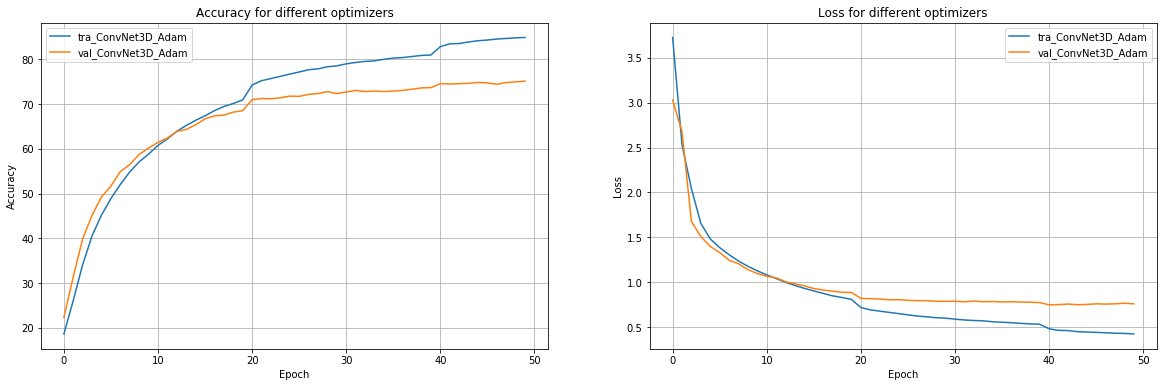

In [3]:
training_curves = {}

for my_cfg in myList:
    
    curve_name_gen(my_cfg)
    
    """ PREPARE DATALOADERS """
    train_dl, val_dl, test_dl, input_dimension_, output_dimension_ = get_dataloader_objects(my_cfg)

    
    """CLASSIFICATION"""
    # Get the model
    model_untrained = get_nn_model(my_cfg, input_dimension=input_dimension_,output_dimension=output_dimension_)

    # Get the optimizer
    optimizer = get_optimizer(my_cfg, model_untrained.parameters())

    # Train and show validation loss
    train_losses, train_accuracies, val_losses, val_accuracies, model_trained, time_spent_for_training_s =\
        fit(train_dl, val_dl, model_untrained, optimizer, my_cfg)
    
    curves = train_losses, train_accuracies, val_losses, val_accuracies, model_trained, time_spent_for_training_s
    training_curves[my_cfg.curve_name] = curves
    
    # Report final accuracy
    test_loss, test_accuracy =  final_test_acc(model_trained, test_dl, my_cfg)
    
    # Save the model
    todays_date = datetime.today().strftime('%Y%m%d_%H%M%S')
    todays_date = 'TrainedModel/'+todays_date
    todays_date_all = todays_date + '_all'
    torch.save(model_trained.state_dict(), todays_date)
    torch.save(model_trained, todays_date_all)

    # Store the results
    results_storer.store_results_for_plot(my_cfg,test_loss, test_accuracy, train_losses,
                                 train_accuracies, time_spent_for_training_s, val_losses, val_accuracies)

    results_storer.store_results(my_cfg, model_trained, optimizer, test_loss, test_accuracy, train_losses,
                                 train_accuracies, time_spent_for_training_s, val_losses, val_accuracies, test_dl)

"""Creates a figure with results and saves it"""
FigName = datetime.today().strftime('%Y%m%d_%H%M%S')
FigName = "Results/Figures/"+ FigName+".eps"
plot_all_metrics(training_curves)
plt.savefig(FigName, format='eps')